In [15]:
# https://github.com/keep9oing/DRQN-Pytorch-CartPole-v1

import sys
from typing import Dict, List, Tuple

import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
import collections
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from environment import PNDEnv


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)


cuda


In [16]:
def make_adjacency_matrix(n: int, density: float) -> np.ndarray:
    """Make adjacency matrix of a clique network.
    
    Args:
        n (int): Number of nodes.
        density (float): Density of the clique network.
    
    Returns:
        np.ndarray: Adjacency matrix.
    """
    if density < 0 or density > 1:
        raise ValueError("Density must be between 0 and 1.")
    
    n_edges = int(n * (n - 1) / 2 * density)
    adjacency_matrix = np.zeros((n, n))
    
    for i in range(1, n):
        adjacency_matrix[i-1, i] = 1
        adjacency_matrix[i, i-1] = 1
        n_edges -= 1
    
    # If the density of the current adjacency matrix is over density, return it.
    if n_edges <= 0:
        return adjacency_matrix
    else:
        arr = [1]*n_edges + [0]*((n-1)*(n-2)//2 - n_edges)
        np.random.shuffle(arr)
        for i in range(0, n):
            for j in range(i+2, n):
                adjacency_matrix[i, j] = arr.pop()
                adjacency_matrix[j, i] = adjacency_matrix[i, j]
    return adjacency_matrix

def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx(G, pos=pos, with_labels=True)
    plt.show()

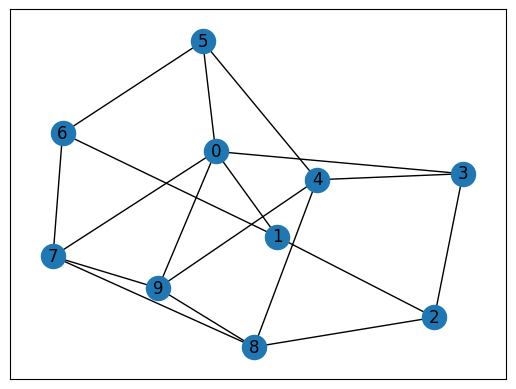

In [25]:
adj = make_adjacency_matrix(10, 0.4)
show_graph_with_labels(adj)

In [ ]:
# Q_network
class Q_net(nn.Module):
    def __init__(self, state_space=None,
                 action_space=None):
        super(Q_net, self).__init__()
        # space size check
        assert state_space is not None, "None state_space input: state_space should be selected."
        assert action_space is not None, "None action_space input: action_space should be selected."

        self.hidden_space = 64
        self.state_space = state_space
        self.action_space = action_space

        self.Linear1 = nn.Linear(self.state_space, self.hidden_space)
        self.lstm    = nn.LSTM(self.hidden_space, self.hidden_space, batch_first=True)
        self.Linear2 = nn.Linear(self.hidden_space, self.action_space)

    def forward(self, x, h, c):
        x = F.relu(self.Linear1(x))
        x, (new_h, new_c) = self.lstm(x,(h,c))
        x = self.Linear2(x)
        return x, new_h, new_c

    def sample_action(self, obs, h,c, epsilon):
        output = self.forward(obs, h,c)
        if random.random() < epsilon:
            return random.randint(0,1), output[1], output[2]
        else:
            return output[0].argmax().item(), output[1] , output[2]
    
    def init_hidden_state(self, batch_size, training=None):
        assert training is not None, "training step parameter should be determined"
        if training is True:
            return torch.zeros([1, batch_size, self.hidden_space]), torch.zeros([1, batch_size, self.hidden_space])
        else:
            return torch.zeros([1, 1, self.hidden_space]), torch.zeros([1, 1, self.hidden_space])

class EpisodeMemory():
    """Episode memory for recurrent agent"""
    def __init__(self, random_update=False, 
                       max_epi_num=100, max_epi_len=500,
                       batch_size=1,
                       lookup_step=None):
        self.random_update = random_update # if False, sequential update
        self.max_epi_num = max_epi_num
        self.max_epi_len = max_epi_len
        self.batch_size = batch_size
        self.lookup_step = lookup_step

        if (random_update is False) and (self.batch_size > 1):
            sys.exit('It is recommend to use 1 batch for sequential update, if you want, erase this code block and modify code')

        self.memory = collections.deque(maxlen=self.max_epi_num)

    def put(self, episode):
        self.memory.append(episode)

    def sample(self):
        sampled_buffer = []

        ##################### RANDOM UPDATE ############################
        if self.random_update: # Random update
            sampled_episodes = random.sample(self.memory, self.batch_size)
            
            check_flag = True # check if every sample data to train is larger than batch size
            min_step = self.max_epi_len

            for episode in sampled_episodes:
                min_step = min(min_step, len(episode)) # get minimum step from sampled episodes

            for episode in sampled_episodes:
                if min_step > self.lookup_step: # sample buffer with lookup_step size
                    idx = np.random.randint(0, len(episode)-self.lookup_step+1)
                    sample = episode.sample(random_update=self.random_update, lookup_step=self.lookup_step, idx=idx)
                    sampled_buffer.append(sample)
                else:
                    idx = np.random.randint(0, len(episode)-min_step+1) # sample buffer with minstep size
                    sample = episode.sample(random_update=self.random_update, lookup_step=min_step, idx=idx)
                    sampled_buffer.append(sample)

        ##################### SEQUENTIAL UPDATE ############################           
        else: # Sequential update
            idx = np.random.randint(0, len(self.memory))
            sampled_buffer.append(self.memory[idx].sample(random_update=self.random_update))

        return sampled_buffer, len(sampled_buffer[0]['obs']) # buffers, sequence_length

    def __len__(self):
        return len(self.memory)


class EpisodeBuffer:
    """A simple numpy replay buffer."""
    def __init__(self):
        self.obs = []
        self.action = []
        self.reward = []
        self.next_obs = []
        self.done = []

    def put(self, transition):
        self.obs.append(transition[0])
        self.action.append(transition[1])
        self.reward.append(transition[2])
        self.next_obs.append(transition[3])
        self.done.append(transition[4])

    def sample(self, random_update=False, lookup_step=None, idx=None) -> Dict[str, np.ndarray]:
        obs = np.array(self.obs)
        action = np.array(self.action)
        reward = np.array(self.reward)
        next_obs = np.array(self.next_obs)
        done = np.array(self.done)

        if random_update is True:
            obs = obs[idx:idx+lookup_step]
            action = action[idx:idx+lookup_step]
            reward = reward[idx:idx+lookup_step]
            next_obs = next_obs[idx:idx+lookup_step]
            done = done[idx:idx+lookup_step]

        return dict(obs=obs,
                    acts=action,
                    rews=reward,
                    next_obs=next_obs,
                    done=done)

    def __len__(self) -> int:
        return len(self.obs)


def train(q_net=None, target_q_net=None, episode_memory=None,
          device=None, 
          optimizer = None,
          batch_size=1,
          learning_rate=1e-3,
          gamma=0.99):

    assert device is not None, "None Device input: device should be selected."

    # Get batch from replay buffer
    samples, seq_len = episode_memory.sample()

    observations = []
    actions = []
    rewards = []
    next_observations = []
    dones = []

    for i in range(batch_size):
        observations.append(samples[i]["obs"])
        actions.append(samples[i]["acts"])
        rewards.append(samples[i]["rews"])
        next_observations.append(samples[i]["next_obs"])
        dones.append(samples[i]["done"])

    observations = np.array(observations)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_observations = np.array(next_observations)
    dones = np.array(dones)

    observations = torch.FloatTensor(observations.reshape(batch_size,seq_len,-1)).to(device)
    actions = torch.LongTensor(actions.reshape(batch_size,seq_len,-1)).to(device)
    rewards = torch.FloatTensor(rewards.reshape(batch_size,seq_len,-1)).to(device)
    next_observations = torch.FloatTensor(next_observations.reshape(batch_size,seq_len,-1)).to(device)
    dones = torch.FloatTensor(dones.reshape(batch_size,seq_len,-1)).to(device)

    h_target, c_target = target_q_net.init_hidden_state(batch_size=batch_size, training=True)

    q_target, _, _ = target_q_net(next_observations, h_target.to(device), c_target.to(device))

    q_target_max = q_target.max(2)[0].view(batch_size,seq_len,-1).detach()
    targets = rewards + gamma*q_target_max*dones


    h, c = q_net.init_hidden_state(batch_size=batch_size, training=True)
    q_out, _, _ = q_net(observations, h.to(device), c.to(device))
    q_a = q_out.gather(2, actions)

    # Multiply Importance Sampling weights to loss        
    loss = F.smooth_l1_loss(q_a, targets)
    
    # Update Network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def save_model(model, path='default.pth'):
        torch.save(model.state_dict(), path)

def seed_torch(seed):
        torch.manual_seed(seed)
        if torch.backends.cudnn.enabled:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True

if __name__ == "__main__":

    # Env parameters
    model_name = "DRQN"
    env_name = "SALOHA"
    seed = 1
    exp_num = 'SEED'+'_'+str(seed)

    # Set gym environment
    # env = gym.make("CartPole-v1")
    env = PNDEnv()
    # env = FlattenObservation(env)

    if torch.cuda.is_available():
        device = torch.device("cuda")

    # Set the seed
    np.random.seed(seed)
    random.seed(seed)
    # seed_torch(seed)
    # env.seed(seed)

    # default `log_dir` is "runs" - we'll be more specific here
    # writer = SummaryWriter('runs/'+env_name+"_"+model_name+"_"+exp_num)
    writer = SummaryWriter(comment="_"+env_name+"_"+model_name+"_"+exp_num)

    # Set parameters
    batch_size = 8
    learning_rate = 1e-3
    buffer_len = int(100000)
    min_epi_num = 16 # Start moment to train the Q network
    episodes = 650
    print_per_iter = 20
    target_update_period = 4
    eps_start = 0.1
    eps_end = 0.001
    eps_decay = 0.995
    tau = 1e-2
    max_step = 2000

    # DRQN param
    random_update = True# If you want to do random update instead of sequential update
    lookup_step = 10 # If you want to do random update instead of sequential update
    max_epi_len = 128
    max_epi_step = max_step

    

    # Create Q functions
    Q = Q_net(state_space=5, # env.observation_space.shape[0]
              action_space=env.action_space.n).to(device)
    Q_target = Q_net(state_space=5, 
                     action_space=env.action_space.n).to(device)

    Q_target.load_state_dict(Q.state_dict())

    # Set optimizer
    score = 0
    score_sum = 0
    optimizer = optim.Adam(Q.parameters(), lr=learning_rate)

    epsilon = eps_start
    
    episode_memory = EpisodeMemory(random_update=random_update, 
                                   max_epi_num=100, max_epi_len=600, 
                                   batch_size=batch_size, 
                                   lookup_step=lookup_step)

    # Train
    for i in range(episodes):
        s, _ = env.reset(seed=seed)
        obs = s
        done = False
        
        episode_record = EpisodeBuffer()
        h, c = Q.init_hidden_state(batch_size=batch_size, training=False)

        for t in range(max_step):

            # Get action
            a, h, c = Q.sample_action(torch.from_numpy(obs).float().to(device).unsqueeze(0).unsqueeze(0), 
                                      h.to(device), 
                                      c.to(device),
                                      epsilon)

            # Do action
            s_prime, r, done, _, _ = env.step(a)
            obs_prime = s_prime

            # make data
            done_mask = 0.0 if done else 1.0

            episode_record.put([obs, a, r/100.0, obs_prime, done_mask])

            obs = obs_prime
            
            score += r
            score_sum += r

            if len(episode_memory) >= min_epi_num:
                train(Q, Q_target, episode_memory, device, 
                        optimizer=optimizer,
                        batch_size=batch_size,
                        learning_rate=learning_rate)

                if (t+1) % target_update_period == 0:
                    # Q_target.load_state_dict(Q.state_dict()) <- navie update
                    for target_param, local_param in zip(Q_target.parameters(), Q.parameters()): # <- soft update
                            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)
                
            if done:
                break
        
        episode_memory.put(episode_record)
        
        epsilon = max(eps_end, epsilon * eps_decay) #Linear annealing

        if i % print_per_iter == 0 and i!=0:
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                            i, score_sum/print_per_iter, len(episode_memory), epsilon*100))
            score_sum=0.0
            save_model(Q, model_name+"_"+exp_num+'.pth')

        # Log the reward
        writer.add_scalar('Rewards per episodes', score, i)
        score = 0
        
    writer.close()
    env.close()